In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from calendar import monthrange
from sklearn.cluster import KMeans

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз?

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. 

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.


Посмотрим на наши данные

In [2]:
olist_customers_datase = pd.read_csv('olist_customers_dataset.csv')

In [3]:
olist_orders_dataset = pd.read_csv('olist_orders_dataset.csv')

In [4]:
olist_order_items_dataset = pd.read_csv('olist_order_items_dataset.csv')

In [5]:
olist_customers_datase.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


 olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
customer_id — позаказный идентификатор пользователя (аналог номера паспорта)

customer_unique_id —  уникальный идентификатор пользователя

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

In [6]:
olist_customers_datase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [7]:
olist_orders_dataset.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


olist_orders_dataset.csv —  таблица заказов
order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя (аналог номера паспорта)

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

In [8]:
olist_orders_dataset.info()
#есть наны order_approved_at, order_delivered_carrier_date, order_delivered_customer_date

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [9]:
olist_order_items_dataset.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

In [10]:
olist_order_items_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [11]:
olist_customers_datase.nunique()
#96096 уникальных пользователей customer_unique_id

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [12]:
olist_orders_dataset.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

## 1. Сколько у нас пользователей, которые совершили покупку только один раз?

Сначала создадим датафрейм с заказами, имеющими разные статусы, кроме статуса отменен

In [13]:
not_canceled = olist_orders_dataset.query('order_status != "canceled"')

In [14]:
not_canceled.info()
#есть наны order_approved_at, order_delivered_carrier_date, order_delivered_customer_date

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98816 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       98816 non-null  object
 1   customer_id                    98816 non-null  object
 2   order_status                   98816 non-null  object
 3   order_purchase_timestamp       98816 non-null  object
 4   order_approved_at              98797 non-null  object
 5   order_delivered_carrier_date   97583 non-null  object
 6   order_delivered_customer_date  96470 non-null  object
 7   order_estimated_delivery_date  98816 non-null  object
dtypes: object(8)
memory usage: 6.8+ MB


Посмотрим на данные, у которых есть нулевые значения

In [15]:
not_approved_at = not_canceled.query('order_approved_at != order_approved_at')

In [16]:
not_approved_at.groupby('order_status').agg({'order_id': 'count'})
#5 заказов созданных и не имеющих информации о времени подтверждения оплаты заказа 

#14 доставленных заказов без данных о времени подтверждения оплаты, видимо был какой-то сбой системы

,order_id
order_status,
created,5
delivered,14


In [17]:
not_delivered_carrier_date = not_canceled.query('order_delivered_carrier_date != order_delivered_carrier_date')

In [18]:
not_delivered_carrier_date.groupby('order_status').agg({'order_id': 'count'})
#есть статус unavailable, надо посмотреть на него внимательней

,order_id
order_status,
approved,2
created,5
delivered,2
invoiced,314
processing,301
unavailable,609


In [19]:
not_canceled.query('order_status == "unavailable"')
#609 заказов неизвестного статуса с известным временем создания заказа, временем подтверждения оплаты, но без 
#времени передачи в логистическую службу и времени доставки
#оставим данные, т.к. есть дата подтверждения оплаты, будем считать, 
#что заказы будут доставлены, когда их статус будет определен

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaN,NaN,2017-12-05 00:00:00
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaN,NaN,2018-02-16 00:00:00
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaN,NaN,2017-09-05 00:00:00
737,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaN,NaN,2018-02-06 00:00:00
1160,2f634e2cebf8c0283e7ef0989f77d217,7353b0fb8e8d9675e3a704c60ca44ebe,unavailable,2017-09-27 20:55:33,2017-09-28 01:32:50,NaN,NaN,2017-10-27 00:00:00
...,...,...,...,...,...,...,...,...
99147,6cf5c427fb11bc5fe8abefa86aa7ba0b,91ac14a1e50bc022eeecf0c2ba37006a,unavailable,2017-10-17 10:53:48,2017-10-19 03:12:43,NaN,NaN,2017-10-27 00:00:00
99233,1c7c8ab324927f5b6e52338bd110bef4,95b1767df51d6fa09402267d8de314df,unavailable,2017-12-23 18:48:09,2017-12-23 18:54:22,NaN,NaN,2018-01-19 00:00:00
99252,aaab15da689073f8f9aa978a390a69d1,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaN,NaN,2018-02-06 00:00:00
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaN,NaN,2017-09-15 00:00:00


In [20]:
not_delivered_customer_date = not_canceled.query('order_delivered_customer_date != order_delivered_customer_date')

In [21]:
not_delivered_customer_date.groupby('order_status').agg({'order_id': 'count'})
#как раз эти 609 заказов с неизвестным статусом

,order_id
order_status,
approved,2
created,5
delivered,8
invoiced,314
processing,301
shipped,1107
unavailable,609


In [22]:
pd.unique(not_canceled.order_status)
#заказы со статусом created, скорее всего еще не покупки, не будем их учитывать

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'created', 'approved'], dtype=object)

In [23]:
df_1 = olist_customers_datase.merge(not_canceled.query('order_status != "created"'), how='right')
#Джоиним по правой таблице, чтобы для каждого заказа был свой пользователей, 
#возможно есть пользователи, которые не совершали еще никаких заказов

In [24]:
df_1.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [25]:
df_1.shape

(98811, 12)

In [26]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98811 entries, 0 to 98810
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   customer_id                    98811 non-null  object
 1   customer_unique_id             98811 non-null  object
 2   customer_zip_code_prefix       98811 non-null  int64 
 3   customer_city                  98811 non-null  object
 4   customer_state                 98811 non-null  object
 5   order_id                       98811 non-null  object
 6   order_status                   98811 non-null  object
 7   order_purchase_timestamp       98811 non-null  object
 8   order_approved_at              98797 non-null  object
 9   order_delivered_carrier_date   97583 non-null  object
 10  order_delivered_customer_date  96470 non-null  object
 11  order_estimated_delivery_date  98811 non-null  object
dtypes: int64(1), object(11)
memory usage: 9.8+ MB


Сгруппируем данные по айди покупателей и посчитаем количество заказов у каждого клиента

In [27]:
customer_count = df_1.groupby('customer_unique_id', as_index=False).agg({'order_id': 'count'})

In [28]:
customer_count.sort_values('order_id')

,customer_unique_id,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1
63232,a931e9c8a672ff5527de39785fa58673,1
63231,a9312d3f089577687589a60c7955baa5,1
63230,a9311df21a0a446cd8a0a749d08c77ac,1
63229,a930016dbc02c5ec1f9703a25414aabb,1
...,...,...
10290,1b6c7548a2a1f9037c1fd3ddfed95f33,7
37594,6469f99c1f9dfae7733b25662e7f1782,7
75646,ca77025e7201e3b30c44b472ff346268,7
23339,3e43e6105506432c953e165fb2acf44c,9


In [29]:
customer_pay_sum = customer_count.query('order_id == 1').order_id.sum()

In [30]:
print(f'Покупателей, сделавших заказ один раз – {customer_pay_sum}')

Покупателей, сделавших заказ один раз – 92633


## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Будем считать количество заказов отмененных и со статусом - неизвестно, т.к. есть вероятность, что заказы со статусом неизвестно не будут доставлены и их потеряли 

In [31]:
olist_orders_dataset.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [32]:
olist_orders_dataset['order_purchase_timestamp'] = olist_orders_dataset['order_purchase_timestamp'].astype('datetime64[ns]')

In [33]:
olist_orders_dataset['order_purchase_timestamp_month'] = olist_orders_dataset['order_purchase_timestamp'].dt.month

In [34]:
olist_orders_dataset['order_purchase_timestamp_year'] = olist_orders_dataset['order_purchase_timestamp'].dt.year

In [35]:
status = olist_orders_dataset.query('order_status == ["canceled", "unavailable"]') \
    .groupby(['order_purchase_timestamp_year', 'order_purchase_timestamp_month', 'order_status'], as_index=False) \
    .agg({'order_id': 'count'}).rename(columns={'order_id': 'count_order_id'})

In [36]:
status
#таблица показывает, сколько заказов было отменено и со статусом - неизвестно, в каждом месяце

,order_purchase_timestamp_year,order_purchase_timestamp_month,order_status,count_order_id
0,2016,9,canceled,2
1,2016,10,canceled,24
2,2016,10,unavailable,7
3,2017,1,canceled,3
4,2017,1,unavailable,10
5,2017,2,canceled,17
6,2017,2,unavailable,45
7,2017,3,canceled,33
8,2017,3,unavailable,32
9,2017,4,canceled,18


In [37]:
status_pivot = status.pivot(index=['order_purchase_timestamp_year', 'order_purchase_timestamp_month'], 
                            columns='order_status', values='count_order_id')

In [38]:
status_pivot

order_status                                                  canceled  \
order_purchase_timestamp_year order_purchase_timestamp_month             
2016                          9                                    2.0   
                              10                                  24.0   
2017                          1                                    3.0   
                              2                                   17.0   
                              3                                   33.0   
                              4                                   18.0   
                              5                                   29.0   
                              6                                   16.0   
                              7                                   28.0   
                              8                                   27.0   
                              9                                   20.0   
                              10                                  26.0   
                              11                                  37.0   
                              12                                  11.0   
2018                          1                                   34.0   
                              2                                   73.0   
                              3                                   26.0   
                              4                                   15.0   
                              5                                   24.0   
                              6                                   18.0   
                              7                                   41.0   
                              8                                   84.0   
                              9                                   15.0   
                              10                                   4.0   

order_status                                                  unavailable  
order_purchase_timestamp_year order_purchase_timestamp_month               
2016                          9                                       NaN  
                              10                                      7.0  
2017                          1                                      10.0  
                              2                                      45.0  
                              3                                      32.0  
                              4                                       9.0  
                              5                                      31.0  
                              6                                      24.0  
                              7                                      52.0  
                              8                                      32.0  
                              9                                      38.0  
                              10                                     58.0  
                              11                                     84.0  
                              12                                     42.0  
2018                          1                                      48.0  
                              2                                      30.0  
                              3                                      17.0  
                              4                                       5.0  
                              5                                      16.0  
                              6                                       4.0  
                              7                                      18.0  
                              8                                       7.0  
                              9                                       NaN  
                              10                                      NaN

In [39]:
status_pivot = status_pivot.reset_index()

In [40]:
status_pivot

order_status,order_purchase_timestamp_year,order_purchase_timestamp_month,canceled,unavailable
0,2016,9,2.0,NaN
1,2016,10,24.0,7.0
2,2017,1,3.0,10.0
3,2017,2,17.0,45.0
4,2017,3,33.0,32.0
5,2017,4,18.0,9.0
6,2017,5,29.0,31.0
7,2017,6,16.0,24.0
8,2017,7,28.0,52.0
9,2017,8,27.0,32.0


In [41]:
status_pivot.describe()

order_status,order_purchase_timestamp_year,order_purchase_timestamp_month,canceled,unavailable
count,24.000000,24.000000,24.000000,21.000000
mean,2017.333333,6.333333,26.041667,29.000000
std,0.637022,3.318809,19.173077,20.825465
min,2016.000000,1.000000,2.000000,4.000000
25%,2017.000000,3.750000,15.750000,10.000000
50%,2017.000000,6.500000,24.000000,30.000000
75%,2018.000000,9.000000,30.000000,42.000000
max,2018.000000,12.000000,84.000000,84.000000


In [42]:
mean_canceled = round(status_pivot.canceled.mean(), 0)

In [43]:
mean_unavailable = round(status_pivot.unavailable.mean(), 0)

In [44]:
print(f'{mean_canceled} заказов не доставляется в среднем по месяцам из-за отмены')
print(f'{mean_unavailable} заказов не доставляется в среднем по месяцам по неизвестным причинам')

26.0 заказов не доставляется в среднем по месяцам из-за отмены
29.0 заказов не доставляется в среднем по месяцам по неизвестным причинам


## 3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

In [45]:
not_canceled.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [46]:
not_canceled.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [47]:
not_canceled.order_purchase_timestamp = pd.to_datetime(not_canceled.order_purchase_timestamp)

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [48]:
not_canceled['day_name'] = not_canceled['order_purchase_timestamp'].dt.day_name()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
not_canceled.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,day_name
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,Tuesday


In [50]:
df_3 = not_canceled.merge(olist_order_items_dataset, how='left')

In [51]:
df_3.nunique()

order_id                         98816
customer_id                      98816
order_status                         7
order_purchase_timestamp         98257
order_approved_at                90301
order_delivered_carrier_date     80951
order_delivered_customer_date    95658
order_estimated_delivery_date      448
day_name                             7
order_item_id                       21
product_id                       32735
seller_id                         3056
shipping_limit_date              92890
price                             5934
freight_value                     6985
dtype: int64

In [52]:
df_3 = df_3.groupby(['product_id', 'day_name'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id':'count_order_id'})

In [53]:
df_3

,product_id,day_name,count_order_id
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
...,...,...,...
60892,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1
60893,fffdb2d0ec8d6a61f0a0a0db3f25b441,Sunday,1
60894,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1
60895,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2


In [54]:
df_3.groupby('product_id', as_index=False) \
    .agg({'count_order_id': 'max'}) \
    .merge(df_3, how='left') \
    .pivot(index='product_id', columns='day_name', values='count_order_id').fillna(0)
#в таблице показаны айди продуктов и день недели, в который товар покупался чаще всего, а значение показывает
#максимальное число покупок в этот день
#пример: товар 00066f42aeeb9f3007548bb9d3f33c38(первый) покупался чаще всего в воскресенье 
#и маскимальное количество этого товара в этот день равно 1
#пример: товар fffdb2d0ec8d6a61f0a0a0db3f25b441(предпоследний) покупался чаще всего во вторник 
#и маскимальное количество этого товара в этот день равно 2

day_name,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
product_id,,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,0.0,0.0,0.0,1.0,0.0,0.0,0.0
00088930e925c41fd95ebfe695fd2655,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0009406fd7479715e4bef61dd91f2462,0.0,0.0,0.0,0.0,1.0,0.0,0.0
000b8f95fcb9e0096488278317764d19,1.0,0.0,0.0,0.0,0.0,0.0,1.0
000d9be29b5207b54e86aa1b1ac54872,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
fff6177642830a9a94a0f2cba5e476d1,0.0,0.0,1.0,1.0,0.0,0.0,0.0
fff81cc3158d2725c0655ab9ba0f712c,0.0,1.0,0.0,0.0,0.0,0.0,0.0
fff9553ac224cec9d15d49f5a263411f,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
df_3 = df_3.groupby('product_id', as_index=False) \
    .agg({'count_order_id': 'max'}) \
    .merge(df_3, how='left') \
    .pivot(index='product_id', columns='day_name', values='count_order_id').fillna(0).stack().to_frame().reset_index() \
    .rename(columns=({0: 'count'})) \
    .query('count > 0')

In [56]:
df_3

,product_id,day_name,count
3,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1.0
12,00088930e925c41fd95ebfe695fd2655,Tuesday,1.0
18,0009406fd7479715e4bef61dd91f2462,Thursday,1.0
21,000b8f95fcb9e0096488278317764d19,Friday,1.0
27,000b8f95fcb9e0096488278317764d19,Wednesday,1.0
...,...,...,...
229113,fff6177642830a9a94a0f2cba5e476d1,Sunday,1.0
229118,fff81cc3158d2725c0655ab9ba0f712c,Monday,1.0
229124,fff9553ac224cec9d15d49f5a263411f,Friday,1.0
229136,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2.0


In [57]:
count_day = list(df_3['count'])

In [58]:
arrays = [list(df_3.product_id), list(df_3.day_name)]

In [59]:
pd.DataFrame({'count': count_day}, index = pd.MultiIndex.from_arrays(arrays, names=('product_id', 'day_name')))

count
product_id                       day_name        
00066f42aeeb9f3007548bb9d3f33c38 Sunday       1.0
00088930e925c41fd95ebfe695fd2655 Tuesday      1.0
0009406fd7479715e4bef61dd91f2462 Thursday     1.0
000b8f95fcb9e0096488278317764d19 Friday       1.0
                                 Wednesday    1.0
...                                           ...
fff6177642830a9a94a0f2cba5e476d1 Sunday       1.0
fff81cc3158d2725c0655ab9ba0f712c Monday       1.0
fff9553ac224cec9d15d49f5a263411f Friday       1.0
fffdb2d0ec8d6a61f0a0a0db3f25b441 Tuesday      2.0
fffe9eeff12fcbd74a2f2b007dde0c58 Wednesday    1.0

[42453 rows x 1 columns]

## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 

In [60]:
df_1.dtypes

customer_id                      object
customer_unique_id               object
customer_zip_code_prefix          int64
customer_city                    object
customer_state                   object
order_id                         object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [61]:
df_1['order_purchase_timestamp'] = df_1['order_purchase_timestamp'].astype('datetime64[ns]')

In [62]:
df_1['year'] = df_1['order_purchase_timestamp'].dt.year

In [63]:
df_1['month'] = df_1['order_purchase_timestamp'].dt.month

In [64]:
df_4 = df_1[['customer_unique_id', 'order_id', 'year', 'month']]

In [65]:
df_4.nunique()
#для 95560 пользователей необходимо узнать среднее в неделю по месяцам

customer_unique_id    95556
order_id              98811
year                      3
month                    12
dtype: int64

Посчитаем общее количество заказов в каждом месяце каждого года

In [66]:
count_order = df_4.groupby(['customer_unique_id', 'year', 'month'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'count_order'})

In [67]:
count_order

,customer_unique_id,year,month,count_order
0,0000366f3b9a7992bf8c76cfdf3221e2,2018,5,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018,5,1
2,0000f46a3911fa3c0805444483337064,2017,3,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017,10,1
4,0004aac84e0df4da2b147fca70cf8255,2017,11,1
...,...,...,...,...
97450,fffcf5a5ff07b0908bd4e2dbc735a684,2017,6,1
97451,fffea47cd6d3cc0a88bd621562a9d061,2017,12,1
97452,ffff371b4d645b6ecea244b27531430a,2017,2,1
97453,ffff5962728ec6157033ef9805bacc48,2018,5,1


 Посчитаем число недель в каждом месяце каждого года

In [68]:
count_order['count_days'] = count_order.apply(lambda x: monthrange(x.year, x.month)[1], axis=1)

In [69]:
count_order['count_week'] = count_order['count_days'] / 7

In [70]:
count_order['mean_count'] = count_order['count_order'] / count_order['count_week']

In [71]:
count_order.sort_values('mean_count')

,customer_unique_id,year,month,count_order,count_days,count_week,mean_count
0,0000366f3b9a7992bf8c76cfdf3221e2,2018,5,1,31,4.428571,0.225806
56890,958ac7760e5484df1496ba5833ab6117,2018,8,1,31,4.428571,0.225806
56893,958cf844b291da7070d18be8bd93aef3,2018,3,1,31,4.428571,0.225806
56894,958d8d0c2c3441ddbe3d776374f45261,2018,5,1,31,4.428571,0.225806
56895,958da6ff0122fa69bc5e1dc0e176abd9,2017,8,1,31,4.428571,0.225806
...,...,...,...,...,...,...,...
14391,25a560b9a6006157838aab1bdbd68624,2017,4,4,30,4.285714,0.933333
61818,a239b8e2fbce33780f1f1912e2ee5275,2017,2,4,28,4.000000,1.000000
68969,b4e4f24de1e8725b74e4a1f4975116ed,2018,2,4,28,4.000000,1.000000
23796,3e43e6105506432c953e165fb2acf44c,2018,2,4,28,4.000000,1.000000


In [72]:
count_order.groupby(['count_order', 'mean_count']).agg({'count_order': 'count'})

count_order
count_order mean_count             
1           0.225806          58370
            0.233333          29728
            0.250000           8065
2           0.451613            734
            0.466667            343
            0.500000            161
3           0.677419             27
            0.700000             13
            0.750000              6
4           0.903226              2
            0.933333              2
            1.000000              3
6           1.354839              1

По нашим данным можно сделать вывод, что в среднем пользователи совершают 1 покупку в месяц, что усложняет расчет количества покупок в среднем по неделям. Максимальное число покупок за месяц равняется 6 и это только в январе 2017 года.

In [73]:
#я не понимаю, как еще можно дополнить вывод, если только сказать, что покупок в среднем по неделям пользователи совершают от 
# 0,23 до 1,35, тоесть от нуля до 1 покупки

## 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут.

In [74]:
df_1

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year,month
0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017,10
1,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018,7
2,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,2018,8
3,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017,11
4,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2018,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98806,39bd1228ee8140590ac3aca26f2dfe00,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,9c5dedf39a927c1b2549525ed64a053c,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,2017,3
98807,1fca14ff2861355f6e5f14306ff977a7,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,2018,2
98808,1aa71eb042121263aafbe80c1b562c9c,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,83c1379a015df1e13d02aae0204711ab,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,2017,8
98809,b331b74b18dc79bcdf6532d51e1637c1,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,2018,1


In [75]:
df_1['OrderPeriod'] = df_1.order_purchase_timestamp.apply(lambda x: x.strftime('%Y-%m'))

In [76]:
min_per = df_1.groupby('customer_unique_id', as_index=False).OrderPeriod.min()

In [77]:
min_per = min_per.rename(columns={'OrderPeriod': 'first_buy'})

In [78]:
df_5 = df_1.merge(min_per, on='customer_unique_id', how='left')

In [79]:
df_5

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year,month,OrderPeriod,first_buy
0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017,10,2017-10,2017-09
1,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018,7,2018-07,2018-07
2,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,2018,8,2018-08,2018-08
3,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017,11,2017-11,2017-11
4,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2018,2,2018-02,2018-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98806,39bd1228ee8140590ac3aca26f2dfe00,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,9c5dedf39a927c1b2549525ed64a053c,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,2017,3,2017-03,2017-03
98807,1fca14ff2861355f6e5f14306ff977a7,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,2018,2,2018-02,2018-02
98808,1aa71eb042121263aafbe80c1b562c9c,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,83c1379a015df1e13d02aae0204711ab,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,2017,8,2017-08,2017-08
98809,b331b74b18dc79bcdf6532d51e1637c1,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,2018,1,2018-01,2018-01


In [80]:
df_5 = df_5.rename(columns={'OrderPeriod': 'buy'})

In [81]:
df_5 = df_5[['customer_unique_id', 'order_purchase_timestamp', 'buy', 'first_buy']]

In [82]:
df_5

,customer_unique_id,order_purchase_timestamp,buy,first_buy
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10,2017-09
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07,2018-07
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08,2018-08
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11,2017-11
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02,2018-02
...,...,...,...,...
98806,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-09 09:54:05,2017-03,2017-03
98807,da62f9e57a76d978d02ab5362c509660,2018-02-06 12:58:58,2018-02,2018-02
98808,737520a9aad80b3fbbdad19b66b37b30,2017-08-27 14:46:43,2017-08,2017-08
98809,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27,2018-01,2018-01


In [83]:
cohorts = df_5.groupby(['first_buy', 'buy']).agg({'customer_unique_id': pd.Series.nunique})

In [84]:
cohorts

customer_unique_id
first_buy buy                        
2016-09   2016-09                   2
2016-10   2016-10                 297
          2017-04                   1
          2017-07                   1
          2017-09                   1
...                               ...
2018-06   2018-08                  16
2018-07   2018-07                6034
          2018-08                  31
2018-08   2018-08                6215
          2018-09                   1

[220 rows x 1 columns]

In [85]:
np.arange(len(cohorts))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [86]:
def cohorts_period(df):
  df['cohorts_period'] = np.arange(len(df))
  return df

In [87]:
cohorts = cohorts.groupby(level=0).apply(cohorts_period)

In [88]:
cohorts

customer_unique_id  cohorts_period
first_buy buy                                        
2016-09   2016-09                   2               0
2016-10   2016-10                 297               0
          2017-04                   1               1
          2017-07                   1               2
          2017-09                   1               3
...                               ...             ...
2018-06   2018-08                  16               2
2018-07   2018-07                6034               0
          2018-08                  31               1
2018-08   2018-08                6215               0
          2018-09                   1               1

[220 rows x 2 columns]

In [89]:
cohorts.reset_index(inplace=True)

In [90]:
cohorts.set_index(['cohorts_period', 'first_buy'], inplace=True)

In [91]:
cohorts

buy  customer_unique_id
cohorts_period first_buy                             
0              2016-09    2016-09                   2
               2016-10    2016-10                 297
1              2016-10    2017-04                   1
2              2016-10    2017-07                   1
3              2016-10    2017-09                   1
...                           ...                 ...
2              2018-06    2018-08                  16
0              2018-07    2018-07                6034
1              2018-07    2018-08                  31
0              2018-08    2018-08                6215
1              2018-08    2018-09                   1

[220 rows x 2 columns]

In [92]:
cohort_group_size = cohorts['customer_unique_id'].groupby('first_buy').first()

In [93]:
cohort_group_size.head()

first_buy
2016-09       2
2016-10     297
2016-12       1
2017-01     762
2017-02    1735
Name: customer_unique_id, dtype: int64

In [94]:
user_retention = cohorts['customer_unique_id'].unstack(1).T.divide(cohort_group_size, axis=0)
user_retention

cohorts_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
first_buy,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,0.003367,0.003367,0.003367,0.003367,0.003367,0.003367,0.006734,0.006734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.003937,0.002625,0.001312,0.003937,0.001312,0.005249,0.001312,0.001312,0.003937,0.001312,0.007874,0.003937,0.001312,0.001312,0.002625,0.003937,0.001312
2017-02,1.0,0.002305,0.002882,0.001153,0.004035,0.001153,0.002305,0.001729,0.001729,0.002305,0.001153,0.002882,0.001729,0.001729,0.001153,0.000576,0.000576,0.002305
2017-03,1.0,0.004994,0.003458,0.003842,0.003458,0.001537,0.001537,0.003073,0.003458,0.000768,0.003842,0.001537,0.002305,0.001153,0.001537,0.002305,0.000768,0.001537
2017-04,1.0,0.005998,0.002142,0.001714,0.002999,0.002571,0.003428,0.002999,0.002999,0.001714,0.002571,0.000857,0.000857,0.000428,0.000857,0.000857,0.001714,NaN
2017-05,1.0,0.004761,0.005041,0.003920,0.003080,0.003360,0.004201,0.001680,0.002520,0.002800,0.002520,0.003360,0.002520,0.000280,0.001960,0.002240,NaN,NaN
2017-06,1.0,0.004479,0.003519,0.004159,0.002559,0.003839,0.003519,0.002239,0.001280,0.002239,0.003199,0.003199,0.001599,0.001280,0.001919,NaN,NaN,NaN


In [95]:
ur_style = (user_retention
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='Greens',low=0.2, high=1, axis =0)
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
ur_style

cohorts_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
first_buy,,,,,,,,,,,,,,,,,,
2016-09,100.00%,,,,,,,,,,,,,,,,,
2016-10,100.00%,0.34%,0.34%,0.34%,0.34%,0.34%,0.34%,0.67%,0.67%,,,,,,,,,
2016-12,100.00%,100.00%,,,,,,,,,,,,,,,,
2017-01,100.00%,0.39%,0.26%,0.13%,0.39%,0.13%,0.52%,0.13%,0.13%,0.39%,0.13%,0.79%,0.39%,0.13%,0.13%,0.26%,0.39%,0.13%
2017-02,100.00%,0.23%,0.29%,0.12%,0.40%,0.12%,0.23%,0.17%,0.17%,0.23%,0.12%,0.29%,0.17%,0.17%,0.12%,0.06%,0.06%,0.23%
2017-03,100.00%,0.50%,0.35%,0.38%,0.35%,0.15%,0.15%,0.31%,0.35%,0.08%,0.38%,0.15%,0.23%,0.12%,0.15%,0.23%,0.08%,0.15%
2017-04,100.00%,0.60%,0.21%,0.17%,0.30%,0.26%,0.34%,0.30%,0.30%,0.17%,0.26%,0.09%,0.09%,0.04%,0.09%,0.09%,0.17%,
2017-05,100.00%,0.48%,0.50%,0.39%,0.31%,0.34%,0.42%,0.17%,0.25%,0.28%,0.25%,0.34%,0.25%,0.03%,0.20%,0.22%,,
2017-06,100.00%,0.45%,0.35%,0.42%,0.26%,0.38%,0.35%,0.22%,0.13%,0.22%,0.32%,0.32%,0.16%,0.13%,0.19%,,,


В период с января по декабрь когорта с самым высоким retention на 3й месяц - 2017-06

## 6. RFM-сегментация пользователей для качественной оценки аудитории.

In [96]:
#Чтобы получить оценку RFM клиента, нам нужно сначала рассчитать оценки R, F и M по шкале от худшего до лучшего.

#рассчитать Recency = количество дней с момента последней покупки
#рассчитать Freqency = количество покупок за исследуемый период
#рассчитать Monetary = общая сумма покупок, сделанных за исследуемый период

Преобразуем данные в удобный формат

In [97]:
pd.unique(df_1.order_status)

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'approved'], dtype=object)

In [98]:
df_1.query('order_status == "unavailable"').order_approved_at.isna().sum()

0

In [99]:
df_1.order_purchase_timestamp.isna().sum()

0

In [100]:
df_1.query('order_approved_at != order_approved_at')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year,month,OrderPeriod
5296,2127dc6603ac33544953ef05ec155771,8a9a08c7ca8900a200d83cf838a07e0b,6708,cotia,SP,e04abd8149ef81b95221e88f6ed9ab6a,delivered,2017-02-18 14:40:00,NaN,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17 00:00:00,2017,2,2017-02
16462,4c1ccc74e00993733742a3c786dc3c1f,91efb7fcabc17925099dced52435837f,93548,novo hamburgo,RS,8a9adc69528e1001fc68dd0aaebbb54a,delivered,2017-02-18 12:45:31,NaN,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21 00:00:00,2017,2,2017-02
18911,2941af76d38100e0f8740a374f1a5dc3,e1f01a1bd6485e58ad3c769a5427d8a8,8230,sao paulo,SP,7013bcfc1c97fe719a7b5e05e61c12db,delivered,2017-02-18 13:29:47,NaN,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17 00:00:00,2017,2,2017-02
22516,29c35fc91fc13fb5073c8f30505d860d,7e1a5ca61b572d76b64b6688b9f96473,62700,caninde,CE,5cf925b116421afa85ee25e99b4c34fb,delivered,2017-02-18 16:48:35,NaN,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31 00:00:00,2017,2,2017-02
23007,1e101e0daffaddce8159d25a8e53f2b2,c8822fce1d0bfa7ddf0da24fff947172,27945,macae,RJ,12a95a3c06dbaec84bcfb0e2da5d228a,delivered,2017-02-17 13:05:55,NaN,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20 00:00:00,2017,2,2017-02
26624,684cb238dc5b5d6366244e0e0776b450,6ff8b0d7b35d5c945633b8d60165691b,11030,santos,SP,c1d4211b3dae76144deccd6c74144a88,delivered,2017-01-19 12:48:08,NaN,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01 00:00:00,2017,1,2017-01
38049,68d081753ad4fe22fc4d410a9eb1ca01,2e0a2166aa23da2472c6a60c4af6f7a6,3573,sao paulo,SP,d69e5d356402adc8cf17e08b5033acfb,delivered,2017-02-19 01:28:47,NaN,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27 00:00:00,2017,2,2017-02
39089,0bf35cac6cc7327065da879e2d90fae8,c4c0011e639bdbcf26059ddc38bd3c18,13225,varzea paulista,SP,d77031d6a3c8a52f019764e68f211c69,delivered,2017-02-18 11:04:19,NaN,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22 00:00:00,2017,2,2017-02
48091,d5de688c321096d15508faae67a27051,d49f3dae6bad25d05160fc17aca5942d,36400,conselheiro lafaiete,MG,7002a78c79c519ac54022d4f8a65e6e8,delivered,2017-01-19 22:26:59,NaN,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16 00:00:00,2017,1,2017-01
61345,a3d3c38e58b9d2dfb9207cab690b6310,5a4fa4919cbf2b049e72be460a380e5b,35620,abaete,MG,2eecb0d85f281280f79fa00f9cec1a95,delivered,2017-02-17 17:21:55,NaN,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20 00:00:00,2017,2,2017-02


In [101]:
df_6 = df_1[['customer_id', 'customer_unique_id', 'order_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date']]

In [102]:
df_6

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date
0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13
1,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45
2,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29
3,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42
4,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02
...,...,...,...,...,...,...,...
98806,39bd1228ee8140590ac3aca26f2dfe00,6359f309b166b0196dbf7ad2ac62bb5a,9c5dedf39a927c1b2549525ed64a053c,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-17 15:08:01
98807,1fca14ff2861355f6e5f14306ff977a7,da62f9e57a76d978d02ab5362c509660,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-28 17:37:56
98808,1aa71eb042121263aafbe80c1b562c9c,737520a9aad80b3fbbdad19b66b37b30,83c1379a015df1e13d02aae0204711ab,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-09-21 11:24:17
98809,b331b74b18dc79bcdf6532d51e1637c1,5097a5312c8b157bb7be58ae360ef43c,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-25 23:32:54


In [103]:
olist_order_items_dataset

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [104]:
df_6 = df_6.merge(olist_order_items_dataset, how='left')

In [105]:
df_6[['customer_unique_id', 'order_purchase_timestamp', 'order_approved_at', 'price']].nunique()

customer_unique_id          95556
order_purchase_timestamp    98252
order_approved_at           90301
price                        5934
dtype: int64

Начнем с расчета величины М — денежной стоимости.

In [106]:
m = df_6[['customer_unique_id', 'order_purchase_timestamp', 'order_approved_at', 'price']] \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'price': 'sum'}).rename(columns={'price': 'monetary'})

In [107]:
m.head()

,customer_unique_id,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
2,0000f46a3911fa3c0805444483337064,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,25.99
4,0004aac84e0df4da2b147fca70cf8255,180.00


Рассчитаем частоту. Мы хотим найти количество раз, когда каждый покупатель совершал покупку. 

In [108]:
f = df_6.groupby('customer_unique_id', as_index=False).agg({'order_purchase_timestamp': 'count'})

In [109]:
f = f.rename(columns={'order_purchase_timestamp': 'frequency'})

In [110]:
f.sort_values('frequency')

,customer_unique_id,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
61585,a4d20ae27169304c8addde9bda407fec,1
61584,a4d0930cca1e47704dc6a35dc942efcb,1
61583,a4d015be0feb92a1a6f955aa522cd956,1
61582,a4cf1b712d67ebba4ec2f4136458ed2d,1
...,...,...
5752,0f5ac8d5c31de21d2f25e24be15bbffb,18
39510,698e1cf81d01a3d389d96145f7fa6df8,20
73246,c402f431464c72e27330a67f7b94d4fb,20
25930,4546caea018ad8c692964e3382debd19,21


Чтобы вычислить количество дней с момента последней покупки, необходимо найти когда последний раз клиент совершал покупку. 

In [111]:
df_6.dtypes

customer_id                              object
customer_unique_id                       object
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                        object
order_delivered_customer_date            object
order_item_id                           float64
product_id                               object
seller_id                                object
shipping_limit_date                      object
price                                   float64
freight_value                           float64
dtype: object

In [112]:
df_6.head()

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [113]:
df_6[['customer_unique_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date']]

,customer_unique_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date
0,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13
1,af07308b275d755c9edb36a90c618231,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45
2,3a653a41f6f9fc3d2a113cf8398680e8,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29
3,7c142cf63193a1473d2e66489a9ae977,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42
4,72632f0f9dd73dfee390c9b22eb56dd6,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02
...,...,...,...,...,...
112709,da62f9e57a76d978d02ab5362c509660,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-28 17:37:56
112710,737520a9aad80b3fbbdad19b66b37b30,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-09-21 11:24:17
112711,5097a5312c8b157bb7be58ae360ef43c,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-25 23:32:54
112712,5097a5312c8b157bb7be58ae360ef43c,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-25 23:32:54


In [114]:
df_6.order_purchase_timestamp.isna().sum()

0

In [115]:
df_6.order_approved_at.isna().sum()

15

In [116]:
df_6.order_delivered_customer_date.isna().sum()

2525

Я использую order_purchase_timestamp потому что это единственная дата, которая есть в датафрейме, без нулевых значений.
Можно посмотреть сколько покупателей совершили одну покупку и посмотреть на даты

In [117]:
df_1['order_approved_at']

0        2017-10-02 11:07:15
1        2018-07-26 03:24:27
2        2018-08-08 08:55:23
3        2017-11-18 19:45:59
4        2018-02-13 22:20:29
                ...         
98806    2017-03-09 09:54:05
98807    2018-02-06 13:10:37
98808    2017-08-27 15:04:16
98809    2018-01-08 21:36:21
98810    2018-03-09 11:20:28
Name: order_approved_at, Length: 98811, dtype: object

In [118]:
df_1['order_approved_at'] = df_1['order_approved_at'].astype('datetime64[ns]')

In [119]:
df_6['order_approved_at'] = df_1['order_approved_at'].astype('datetime64[ns]')

In [120]:
df_6['diff_d'] = (df_6['order_approved_at']-df_6['order_purchase_timestamp']).dt.days

In [121]:
df_6.diff_d.value_counts(normalize=True).sort_values().mul(100).round(2)

-648.0    0.00
-679.0    0.00
 650.0    0.00
-585.0    0.00
 608.0    0.00
          ... 
 9.0      0.21
-1.0      0.21
-5.0      0.21
 0.0      0.22
 2.0      0.24
Name: diff_d, Length: 1277, dtype: float64

In [122]:
df_6.diff_d.mode()

0    2.0
dtype: float64

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


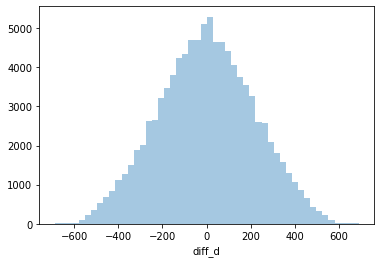

In [123]:
sns.distplot(df_6['diff_d'], kde = False)

In [124]:
df_6.query('diff_d < 0')
#данные имеют странный характер. Я не понимаю, как может дата оплаты товара быть меньше даты создания заказа

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,diff_d
14,19402a48fe860416adf93348aba37740,e2dfa3127fedbbca9707b36304996dab,5ff96c15d0b717ac6ad1f3d77225a350,delivered,2018-07-25 17:44:10,2018-03-01 15:10:47,2018-07-30 15:52:25,1.0,10adb53d8faa890ca7c2f0cbcb68d777,1900267e848ceeba8fa32d80c1a5f5a8,2018-07-27 17:55:14,19.90,12.80,-147.0
16,3b6828a50ffe546942b7a473d70ac0fc,ccafc1c3f270410521c3c6f3b249870f,dcb36b511fcac050b97cd5c05de84dc3,delivered,2018-06-07 19:03:12,2018-01-02 19:09:04,2018-06-21 15:34:32,1.0,009c09f439988bc06a93d6b8186dce73,89a51f50b8095ea78d5768f34c13a76f,2018-06-18 18:59:02,132.40,14.05,-156.0
17,738b086814c6fcc74b8cc583f8516ee3,6e26bbeaa107ec34112c64e1ee31c0f5,403b97836b0c04a622354cf531062e5f,delivered,2018-01-02 19:00:43,2017-12-26 23:50:22,2018-01-20 01:38:59,1.0,638bbb2a5e4f360b71f332ddfebfd672,c4af86330efa7a2620772227d2d670c9,2018-01-12 19:09:04,1299.00,77.45,-7.0
18,3187789bec990987628d7a9beb4dd6ac,6087cfc70fd833cf2db637a5e6e9d76b,116f0b09343b49556bbad5f35bee0cdf,delivered,2017-12-26 23:41:31,2017-11-21 00:14:22,2018-01-08 22:36:36,1.0,a47295965bd091207681b541b26e40a5,ea8482cd71df3c1969d7b9473ff13abc,2018-01-02 23:50:22,27.99,15.10,-36.0
19,059f7fc5719c7da6cbafe370971a8d70,d0ff1a7468fcc46b8fc658ab35d2a12c,85ce859fd6dc634de8d2f1e290444043,delivered,2017-11-21 00:03:41,2017-10-26 16:08:14,2017-11-27 18:28:00,1.0,cce679660c66e6fbd5c8091dfd29e9cd,d2374cbcbb3ca4ab1086534108cc3ab7,2017-11-29 00:14:22,17.90,11.85,-26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98803,2c23489c329798c266c3ffcd50dbdcf8,66f4eec9da64df09009a7f397c2a32b1,5cb890a68b91b6158d69257e4e2bc359,delivered,2018-01-24 12:33:57,2017-10-04 20:07:14,2018-02-01 21:43:45,1.0,4f4524396824b581a27a7dcebb2938b5,76d64c4aca3a7baf218bf93ef7fa768d,2018-01-31 12:31:18,269.90,19.82,-112.0
98804,2c23489c329798c266c3ffcd50dbdcf8,66f4eec9da64df09009a7f397c2a32b1,5cb890a68b91b6158d69257e4e2bc359,delivered,2018-01-24 12:33:57,2017-01-27 01:05:25,2018-02-01 21:43:45,2.0,f777c903946dd86fd00cd5b32ec3e907,4a3ccda38b2129705f3fb522db62ca31,2018-01-31 12:31:18,561.90,19.82,-363.0
98805,115e82e1390fcccdbd8cf09000012a94,2ad36ab08a6c2ea54746c016f997c647,8df5cf9e272e804f5330340384db94d6,delivered,2018-01-19 09:30:05,2017-02-23 09:15:11,2018-01-30 23:57:04,1.0,6413f7a28e149a324c4a914000399fb2,7a67c85e85bb2ce8582c35f2203ad736,2018-01-25 09:39:28,144.99,20.25,-331.0
98806,55e87651358d96661db34c9ad0082e7a,4e00a4d106850f152e72c6a731921c19,e77f560df130ed0c0170ca3c556ea1d5,delivered,2018-06-17 08:53:07,2017-03-09 09:54:05,2018-06-28 11:56:19,1.0,3fbc0ef745950c7932d5f2a446189725,06a2c3af7b3aee5d69171b0e14f0ee87,2018-06-26 09:13:26,66.99,23.19,-465.0


In [125]:
df_6['order_delivered_customer_date'] = df_1['order_delivered_customer_date'].astype('datetime64[ns]')

In [126]:
df_6['diff_d_delivery'] = (df_6['order_delivered_customer_date']-df_6['order_purchase_timestamp']).dt.days

In [127]:
df_6.query('diff_d < 0')

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,diff_d,diff_d_delivery
14,19402a48fe860416adf93348aba37740,e2dfa3127fedbbca9707b36304996dab,5ff96c15d0b717ac6ad1f3d77225a350,delivered,2018-07-25 17:44:10,2018-03-01 15:10:47,2018-03-12 23:36:26,1.0,10adb53d8faa890ca7c2f0cbcb68d777,1900267e848ceeba8fa32d80c1a5f5a8,2018-07-27 17:55:14,19.90,12.80,-147.0,-135.0
16,3b6828a50ffe546942b7a473d70ac0fc,ccafc1c3f270410521c3c6f3b249870f,dcb36b511fcac050b97cd5c05de84dc3,delivered,2018-06-07 19:03:12,2018-01-02 19:09:04,2018-01-20 01:38:59,1.0,009c09f439988bc06a93d6b8186dce73,89a51f50b8095ea78d5768f34c13a76f,2018-06-18 18:59:02,132.40,14.05,-156.0,-139.0
17,738b086814c6fcc74b8cc583f8516ee3,6e26bbeaa107ec34112c64e1ee31c0f5,403b97836b0c04a622354cf531062e5f,delivered,2018-01-02 19:00:43,2017-12-26 23:50:22,2018-01-08 22:36:36,1.0,638bbb2a5e4f360b71f332ddfebfd672,c4af86330efa7a2620772227d2d670c9,2018-01-12 19:09:04,1299.00,77.45,-7.0,6.0
18,3187789bec990987628d7a9beb4dd6ac,6087cfc70fd833cf2db637a5e6e9d76b,116f0b09343b49556bbad5f35bee0cdf,delivered,2017-12-26 23:41:31,2017-11-21 00:14:22,2017-11-27 18:28:00,1.0,a47295965bd091207681b541b26e40a5,ea8482cd71df3c1969d7b9473ff13abc,2018-01-02 23:50:22,27.99,15.10,-36.0,-30.0
19,059f7fc5719c7da6cbafe370971a8d70,d0ff1a7468fcc46b8fc658ab35d2a12c,85ce859fd6dc634de8d2f1e290444043,delivered,2017-11-21 00:03:41,2017-10-26 16:08:14,2017-11-08 22:22:00,1.0,cce679660c66e6fbd5c8091dfd29e9cd,d2374cbcbb3ca4ab1086534108cc3ab7,2017-11-29 00:14:22,17.90,11.85,-26.0,-13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98803,2c23489c329798c266c3ffcd50dbdcf8,66f4eec9da64df09009a7f397c2a32b1,5cb890a68b91b6158d69257e4e2bc359,delivered,2018-01-24 12:33:57,2017-10-04 20:07:14,2017-10-20 20:25:45,1.0,4f4524396824b581a27a7dcebb2938b5,76d64c4aca3a7baf218bf93ef7fa768d,2018-01-31 12:31:18,269.90,19.82,-112.0,-96.0
98804,2c23489c329798c266c3ffcd50dbdcf8,66f4eec9da64df09009a7f397c2a32b1,5cb890a68b91b6158d69257e4e2bc359,delivered,2018-01-24 12:33:57,2017-01-27 01:05:25,2017-02-07 13:15:25,2.0,f777c903946dd86fd00cd5b32ec3e907,4a3ccda38b2129705f3fb522db62ca31,2018-01-31 12:31:18,561.90,19.82,-363.0,-351.0
98805,115e82e1390fcccdbd8cf09000012a94,2ad36ab08a6c2ea54746c016f997c647,8df5cf9e272e804f5330340384db94d6,delivered,2018-01-19 09:30:05,2017-02-23 09:15:11,2017-03-06 11:08:08,1.0,6413f7a28e149a324c4a914000399fb2,7a67c85e85bb2ce8582c35f2203ad736,2018-01-25 09:39:28,144.99,20.25,-331.0,-319.0
98806,55e87651358d96661db34c9ad0082e7a,4e00a4d106850f152e72c6a731921c19,e77f560df130ed0c0170ca3c556ea1d5,delivered,2018-06-17 08:53:07,2017-03-09 09:54:05,2017-03-17 15:08:01,1.0,3fbc0ef745950c7932d5f2a446189725,06a2c3af7b3aee5d69171b0e14f0ee87,2018-06-26 09:13:26,66.99,23.19,-465.0,-457.0


In [128]:
df_6.diff_d_delivery.value_counts(normalize=True).sort_values().mul(100).round(2)

-614.0    0.00
-582.0    0.00
 591.0    0.00
 669.0    0.00
-641.0    0.00
          ... 
-6.0      0.21
 14.0     0.22
 21.0     0.22
 8.0      0.22
 35.0     0.23
Name: diff_d_delivery, Length: 1264, dtype: float64

In [129]:
df_6.query('order_delivered_customer_date != order_delivered_customer_date')

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,diff_d,diff_d_delivery
6,ed0271e0b7da060a393796590e7b737a,36edbb3fb164b1f16485364b6fb04c73,136cce7faa42fdb2cefd53fdc79a6098,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,1.0,a1804276d9941ac0733cfd409f5206eb,dc8798cbf453b7e0f98745e396cc5616,2017-04-19 13:25:17,49.90,16.05,2.0,NaN
44,8644be24d48806bc3a88fd59fb47ceb1,4ca5f90433afb5493247f0bafb583483,948097deef559c742e7ce321e5e58919,delivered,2017-08-04 17:10:39,2018-06-05 04:31:18,NaT,1.0,cd935d283d47f1050c505e1c39c48b67,a3a38f4affed601eb87a97788c949667,2017-08-10 17:25:11,69.90,25.77,304.0,NaN
103,64fb950e760ec8b0db79154a1fa9c1bf,b11b7871c2b8be2d11fab954f58542f2,9defaf92cff22420e4e8ef7784815a55,delivered,2018-05-11 13:10:51,2018-08-07 06:15:14,NaT,1.0,cf944645d4ff2a3eed3ae17f641ea861,a6fe7de3d16f6149ffe280349a8535a0,2018-05-23 13:30:30,49.90,12.79,87.0,NaN
128,a4a2abd07b1cdd4902cf245cdfa1451d,337bf0efbf9e5ba67461d2e5b4e5c2b1,80d817467dc3d0a4bb5ab8986c962b1f,delivered,2018-08-22 16:10:29,2017-09-03 14:30:09,NaT,2.0,425db55cb3b0f5b18a2d9964da31c3c0,2a84855fd20af891be03bc5924d2b453,2018-08-24 16:25:19,49.90,16.54,-354.0,NaN
154,62ffae18a7ca4b2e681c6296180ae346,81cfe11d1b667c768e77b6a9db5fe9b3,b16cec67cb3f5a4bb31abe8988b43d19,delivered,2018-03-26 09:14:26,2018-01-11 02:32:30,NaT,1.0,17efcba3c09566b89c945ef563f381d2,3f9c56764fabca627406093dcb3ef0b4,2018-03-30 09:28:24,129.90,11.77,-75.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112709,1fca14ff2861355f6e5f14306ff977a7,da62f9e57a76d978d02ab5362c509660,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02-06 12:58:58,NaT,NaT,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10,NaN,NaN
112710,1aa71eb042121263aafbe80c1b562c9c,737520a9aad80b3fbbdad19b66b37b30,83c1379a015df1e13d02aae0204711ab,delivered,2017-08-27 14:46:43,NaT,NaT,1.0,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02,NaN,NaN
112711,b331b74b18dc79bcdf6532d51e1637c1,5097a5312c8b157bb7be58ae360ef43c,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08 21:28:27,NaT,NaT,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,NaN,NaN
112712,b331b74b18dc79bcdf6532d51e1637c1,5097a5312c8b157bb7be58ae360ef43c,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08 21:28:27,NaT,NaT,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,NaN,NaN


Мы рассматриваем три даты: дата создания заказа, дата оплаты и дата доставки. Для расчета frecuency будем использовать дату оплаты товара, а вместо тех дат, в которых нулевые значения будем использовать дату создания заказа плюс два дня, т.к. разница в два дня между данными датам самая часто встречаемая 0.24%

In [130]:
df_6_frequency = df_6[['customer_unique_id', 'order_approved_at']].dropna()

In [131]:
df_6_frequency_1 = df_6.query('order_approved_at != order_approved_at')[['customer_unique_id', 'order_purchase_timestamp']]

In [132]:
df_6_frequency_1

,customer_unique_id,order_purchase_timestamp
5296,a073c8fcbfa7ae775d613d19816f2b1d,2017-12-03 11:51:39
16462,0138dff42973f40e8f5225472526f278,2018-04-30 08:34:14
18911,842bff27a9fd73c774aeb526d0f53113,2017-10-08 23:29:17
22516,6727b0932d03a7dd420b9ddffcc51257,2017-08-14 20:28:35
23007,db4bbb056fbe0295f71a36271c3d7351,2018-06-24 18:53:27
...,...,...
112709,da62f9e57a76d978d02ab5362c509660,2018-02-06 12:58:58
112710,737520a9aad80b3fbbdad19b66b37b30,2017-08-27 14:46:43
112711,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27
112712,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27


In [133]:
df_6_frequency_1['order_approved_at'] = df_6_frequency_1['order_purchase_timestamp'] + pd.Timedelta("2 day")

In [134]:
df_6_frequency_1[['customer_unique_id', 'order_approved_at']]

,customer_unique_id,order_approved_at
5296,a073c8fcbfa7ae775d613d19816f2b1d,2017-12-05 11:51:39
16462,0138dff42973f40e8f5225472526f278,2018-05-02 08:34:14
18911,842bff27a9fd73c774aeb526d0f53113,2017-10-10 23:29:17
22516,6727b0932d03a7dd420b9ddffcc51257,2017-08-16 20:28:35
23007,db4bbb056fbe0295f71a36271c3d7351,2018-06-26 18:53:27
...,...,...
112709,da62f9e57a76d978d02ab5362c509660,2018-02-08 12:58:58
112710,737520a9aad80b3fbbdad19b66b37b30,2017-08-29 14:46:43
112711,5097a5312c8b157bb7be58ae360ef43c,2018-01-10 21:28:27
112712,5097a5312c8b157bb7be58ae360ef43c,2018-01-10 21:28:27


In [135]:
recent = pd.concat([df_6_frequency, df_6_frequency_1[['customer_unique_id', 'order_approved_at']]])

In [136]:
df_6.shape

(112714, 15)

In [137]:
recent

,customer_unique_id,order_approved_at
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 11:07:15
1,af07308b275d755c9edb36a90c618231,2018-07-26 03:24:27
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:55:23
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:45:59
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 22:20:29
...,...,...
112709,da62f9e57a76d978d02ab5362c509660,2018-02-08 12:58:58
112710,737520a9aad80b3fbbdad19b66b37b30,2017-08-29 14:46:43
112711,5097a5312c8b157bb7be58ae360ef43c,2018-01-10 21:28:27
112712,5097a5312c8b157bb7be58ae360ef43c,2018-01-10 21:28:27


In [138]:
df_6.sort_values(['order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date'], ascending=False).head()
#есть самая новая дата 2018-09-03, будем отталкиваться от нее

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,diff_d,diff_d_delivery
70533,4b7decb9b58e2569548b8b4c8e20e8d7,ff22e30958c13ffe219db7d711e8f564,54282e97f61c23b78330c15b154c867d,shipped,2018-09-03 09:06:57,2018-05-31 14:54:40,2018-06-24 00:52:25,1.0,b98992ea80b467987a7fbb88e7f2076a,25be943a321c8938947bdaabca979a90,2018-09-05 17:30:54,145.00,21.46,-95.0,-72.0
99727,898b7fee99c4e42170ab69ba59be0a8b,24ac2b4327e25baf39f2119e4228976a,35a972d7f8436f405b56e36add1a7140,delivered,2018-08-29 15:00:37,NaT,NaT,1.0,d04857e7b4b708ee8b8b9921163edba3,9f505651f4a6abe901a56cdc21508025,2018-08-31 15:10:26,84.99,8.76,NaN,NaN
78906,496630b6740bcca28fce9ba50d8a26ef,b701bebbdf478f5500348f03aff62121,03ef5dedbe7492bdae72eec50764c43f,delivered,2018-08-29 14:52:00,2018-05-01 02:36:17,2018-05-09 13:58:34,1.0,c7f27c5bef2338541c772b5776403e6a,7d7866a99a8656a42c7ff6352a433410,2018-08-31 15:05:22,24.90,8.33,-121.0,-113.0
35698,6e353700bc7bcdf6ebc15d6de16d7002,7febafa06d9d8f232a900a2937f04338,168626408cb32af0ffaf76711caae1dc,delivered,2018-08-29 14:18:28,2018-08-12 20:25:14,2018-08-22 15:27:37,1.0,bdcf6a834e8faa30dac3886c7a58e92e,2a84855fd20af891be03bc5924d2b453,2018-08-31 14:30:23,45.90,15.39,-17.0,-7.0
34067,e60df9449653a95af4549bbfcb18a6eb,5c58de6fb80e93396e2f35642666b693,0b223d92c27432930dfe407c6aea3041,delivered,2018-08-29 14:18:23,2018-08-14 04:44:20,2018-08-24 20:48:30,1.0,2b4472df15512a2825ae86fd9ae79335,67bf6941ba2f1fa1d02c375766bc3e53,2018-08-31 14:30:19,209.00,46.48,-16.0,-5.0


In [139]:
recent = recent.groupby('customer_unique_id', as_index=False).agg({'order_approved_at': 'max'})

In [140]:
recent['date'] = pd.to_datetime("2018-09-03")

In [141]:
recent['diff_day'] = recent['date'].dt.date - recent['order_approved_at'].dt.date

In [142]:
recent.sort_values('diff_day')

,customer_unique_id,order_approved_at,date,diff_day
84467,e20b87f018e946b22b3b99a24109e52e,2018-09-03 17:40:06,2018-09-03,0 days
13751,24ac2b4327e25baf39f2119e4228976a,2018-08-31 15:00:37,2018-09-03,3 days
45656,7a22d14aa3c3599238509ddca4b93b01,2018-08-31 12:25:59,2018-09-03,3 days
4689,0c6d7218d5f3fa14514fd29865269993,2018-08-31 09:48:09,2018-09-03,3 days
41364,6e7bfbc2f1b96b9be02a19a233d98e0f,2018-08-30 14:37:52,2018-09-03,4 days
...,...,...,...,...
68498,b748a37303fb3bc57594cfcaec33bad3,2016-10-04 14:46:48,2018-09-03,699 days
39391,693ee9977fc446f5e0be7da006412155,2016-10-04 13:47:45,2018-09-03,699 days
46788,7d0da8d4151694f43095acfe2496f321,2016-10-04 13:26:11,2018-09-03,699 days
62010,a5ea267ed08cc63f6848c14b2f2ec313,2016-10-04 09:43:32,2018-09-03,699 days


In [143]:
recent.diff_day.value_counts(normalize=True).mul(100).round(2)

132 days    0.96
60 days     0.73
283 days    0.71
282 days    0.65
27 days     0.49
            ... 
3 days      0.00
605 days    0.00
606 days    0.00
718 days    0.00
0 days      0.00
Name: diff_day, Length: 616, dtype: float64

In [144]:
recent.diff_day.max()

Timedelta('718 days 00:00:00')

In [145]:
718/5

143.6

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


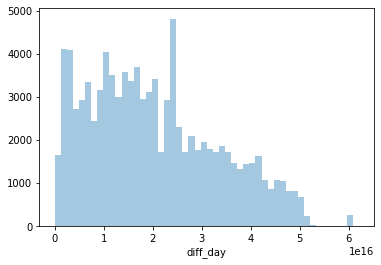

In [146]:
sns.distplot(recent['diff_day'], kde = False)

In [147]:
recent

,customer_unique_id,order_approved_at,date,diff_day
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-11 10:17:40,2018-09-03,115 days
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-21 18:55:22,2018-09-03,105 days
2,0000f46a3911fa3c0805444483337064,2018-05-14 16:52:51,2018-09-03,112 days
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-14 20:29:41,2018-09-03,324 days
4,0004aac84e0df4da2b147fca70cf8255,2018-07-02 22:50:18,2018-09-03,63 days
...,...,...,...,...
95551,fffcf5a5ff07b0908bd4e2dbc735a684,2018-04-17 20:51:45,2018-09-03,139 days
95552,fffea47cd6d3cc0a88bd621562a9d061,2018-02-27 14:55:30,2018-09-03,188 days
95553,ffff371b4d645b6ecea244b27531430a,2017-10-23 22:25:37,2018-09-03,315 days
95554,ffff5962728ec6157033ef9805bacc48,2018-05-04 15:17:41,2018-09-03,122 days


In [148]:
finaldf = f.merge(m,on='customer_unique_id').merge(recent,on='customer_unique_id') 

In [149]:
finaldf = finaldf[['customer_unique_id', 'frequency', 'monetary', 'diff_day']].rename(columns=({'diff_day': 'recency'}))

In [150]:
finaldf

,customer_unique_id,frequency,monetary,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,115 days
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,105 days
2,0000f46a3911fa3c0805444483337064,1,69.00,112 days
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,324 days
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,63 days
...,...,...,...,...
95551,fffcf5a5ff07b0908bd4e2dbc735a684,2,1570.00,139 days
95552,fffea47cd6d3cc0a88bd621562a9d061,1,64.89,188 days
95553,ffff371b4d645b6ecea244b27531430a,1,89.90,315 days
95554,ffff5962728ec6157033ef9805bacc48,1,115.00,122 days


In [151]:
finaldf.recency = finaldf.recency.astype('str').str.split(" days").str[0].astype(int)

In [152]:
finaldf.dtypes

customer_unique_id     object
frequency               int64
monetary              float64
recency                 int64
dtype: object

In [153]:
finaldf

,customer_unique_id,frequency,monetary,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,115
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,105
2,0000f46a3911fa3c0805444483337064,1,69.00,112
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,324
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,63
...,...,...,...,...
95551,fffcf5a5ff07b0908bd4e2dbc735a684,2,1570.00,139
95552,fffea47cd6d3cc0a88bd621562a9d061,1,64.89,188
95553,ffff371b4d645b6ecea244b27531430a,1,89.90,315
95554,ffff5962728ec6157033ef9805bacc48,1,115.00,122


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


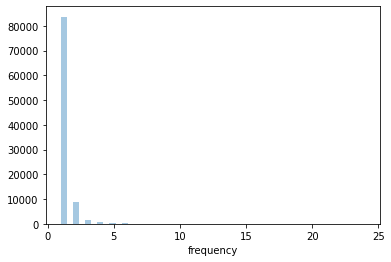

In [154]:
sns.distplot(finaldf['frequency'], kde = False)

In [155]:
finaldf['frequency'].value_counts()

1     83718
2      8981
3      1670
4       628
5       246
6       196
7        46
8        16
9        11
10       11
11       11
12        9
14        3
13        2
15        2
20        2
21        1
17        1
18        1
24        1
Name: frequency, dtype: int64

In [156]:
finaldf['frequency'].describe()

count    95556.000000
mean         1.179560
std          0.619525
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         24.000000
Name: frequency, dtype: float64

Мы собираемся применить кластеризацию K-средних, чтобы назначить оценки. Но мы должны понять, сколько кластеров нам нужно для K-среднего алгоритма. Чтобы это выяснить, мы применим метод локтя. Метод локтя просто сообщает оптимальное число кластеров для оптимальной инерции. Фрагмент кода и график инерции выглядят следующим образом:

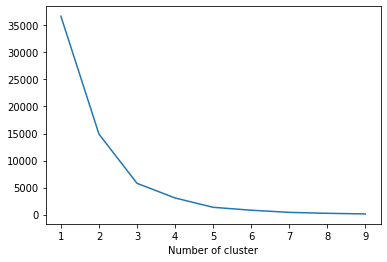

In [157]:
sse={}
tx_frequency = finaldf['frequency'].to_frame()
for k in range(1, 10):
    kmeans_f = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)
    finaldf['clusters'] = kmeans_f.labels_
    sse[k] = kmeans_f.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Здесь, похоже, 3 является оптимальным. Основываясь на бизнес-требованиях, мы можем работать с меньшим или большим количеством кластеров. Мы будем выбирать 3 для этого примера:

In [158]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(finaldf['frequency'].to_frame())
finaldf['frequency_cluster'] = kmeans.predict(finaldf[['frequency']])

def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

finaldf = order_cluster('frequency_cluster', 'frequency',finaldf,True)

In [159]:
finaldf

,customer_unique_id,frequency,monetary,recency,clusters,frequency_cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,115,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,105,0,0
2,0000f46a3911fa3c0805444483337064,1,69.00,112,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,324,0,0
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,63,0,0
...,...,...,...,...,...,...
95551,fe86d9409d83a3c561ce16e64d2d55e6,6,146.00,16,5,2
95552,ff5f29fbfd0a13f7e7ed9f7b92a32194,4,379.60,69,1,2
95553,ff7f36f6ba0f1126bb95b635322cf9d2,6,179.94,28,5,2
95554,ffbb6557e45f7158781514f0efddb0d5,4,91.60,17,1,2


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


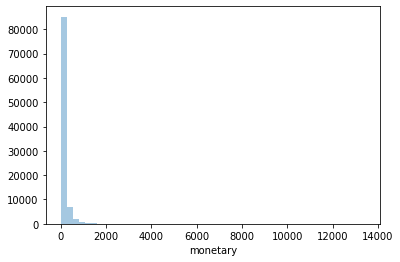

In [160]:
sns.distplot(finaldf['monetary'], kde = False)

In [161]:
finaldf['monetary'].value_counts()

59.90     1604
69.90     1493
49.90     1335
89.90     1153
99.90     1128
          ... 
495.60       1
643.99       1
24.18        1
298.99       1
291.80       1
Name: monetary, Length: 8570, dtype: int64

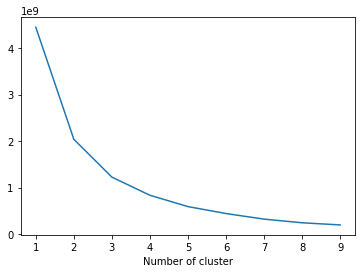

In [162]:
sse_m={}
tx_monetary = finaldf['monetary'].to_frame()
for k in range(1, 10):
    kmeans_m = KMeans(n_clusters=k, max_iter=1000).fit(tx_monetary)
    finaldf['clusters_m'] = kmeans_m.labels_
    sse_m[k] = kmeans_m.inertia_ 
plt.figure()
plt.plot(list(sse_m.keys()), list(sse_m.values()))
plt.xlabel("Number of cluster")
plt.show()

In [163]:
kmeans.fit(finaldf['monetary'].to_frame())
finaldf['monetary_cluster'] = kmeans.predict(finaldf[['monetary']])
finaldf = order_cluster('monetary_cluster', 'monetary',finaldf,True)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


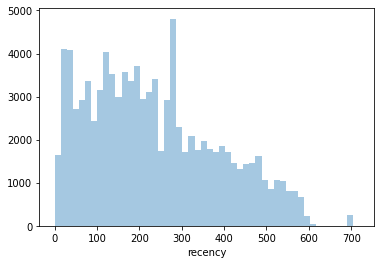

In [164]:
sns.distplot(finaldf['recency'], kde = False)

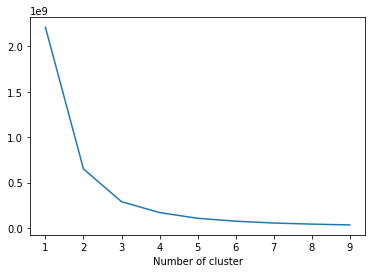

In [165]:
sse_r={}
tx_recency = finaldf['recency'].to_frame()
for k in range(1, 10):
    kmeans_r = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    finaldf['clusters_r'] = kmeans_r.labels_
    sse_r[k] = kmeans_r.inertia_ 
plt.figure()
plt.plot(list(sse_r.keys()), list(sse_r.values()))
plt.xlabel("Number of cluster")
plt.show()

In [166]:
kmeans.fit(finaldf['recency'].to_frame())
finaldf['recency_cluster'] = kmeans.predict(finaldf[['recency']])

finaldf = order_cluster('recency_cluster', 'recency',finaldf,False)

In [167]:
finaldf

,customer_unique_id,frequency,monetary,recency,clusters,frequency_cluster,clusters_m,monetary_cluster,clusters_r,recency_cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,115,0,0,7,0,1,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,105,0,0,3,0,1,2
2,0000f46a3911fa3c0805444483337064,1,69.00,112,0,0,3,0,1,2
3,0004aac84e0df4da2b147fca70cf8255,1,180.00,63,0,0,0,0,3,2
4,00050ab1314c0e55a6ca13cf7181fecf,1,27.99,76,0,0,3,0,1,2
...,...,...,...,...,...,...,...,...,...,...
95551,5457ae2c352c18e3bf5cba68301d96a8,2,1174.90,382,2,1,6,2,0,0
95552,d3bf48abdd573e74110b3e79d7b07ed1,2,1700.00,401,2,1,2,2,0,0
95553,f6255a326ff4c43107bc0f42f433be94,2,1650.80,430,2,1,2,2,0,0
95554,1d10557878391272c010c263dba24b66,4,1596.00,517,1,2,2,2,6,0


In [168]:
finaldf.groupby('frequency_cluster').agg({'frequency': ['min', 'max', 'size']})

frequency           
                        min max   size
frequency_cluster                     
0                         1   1  83718
1                         2   3  10651
2                         4  24   1187

In [169]:
finaldf.groupby('monetary_cluster').agg({'monetary': ['min', 'max', 'size']})

monetary                 
                      min       max   size
monetary_cluster                          
0                     0.0    283.20  86078
1                   283.8   1074.38   8608
2                  1079.9  13440.00    870

In [170]:
finaldf.groupby('recency_cluster').agg({'recency': ['min', 'max', 'size']})

recency            
                    min  max   size
recency_cluster                    
0                   359  718  21218
1                   173  358  35797
2                     0  172  38541

Итак, у нас получилось 27 сегментов (3*3*3) с оценками вида 111, 112, 113, 121, 131 и так далее до 333.